# Titanic

In [1]:
%matplotlib inline

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

##Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

##Settings
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.3f}'.format
from IPython.display import display, HTML

### Loading and check data

In [4]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
trainId=train["PassengerId"]
testId=test["PassengerId"]
df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [5]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.3,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.1,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [6]:
df.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1304,nan,NaN,S,8.1,"Spector, Mr. Woolf",0,1305,3,male,0,nan,A.5. 3236
1305,39.0,C105,C,108.9,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,nan,PC 17758
1306,38.5,NaN,S,7.2,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,nan,SOTON/O.Q. 3101262
1307,nan,NaN,S,8.1,"Ware, Mr. Frederick",0,1308,3,male,0,nan,359309
1308,nan,NaN,C,22.4,"Peter, Master. Michael J",1,1309,3,male,1,nan,2668


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 97.2+ KB


In [8]:
df.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.0,1308.0,1309.0,1309.0,1309.0,1309.0,891.0
mean,29.9,33.3,0.4,655.0,2.3,0.5,0.4
std,14.4,51.8,0.9,378.0,0.8,1.0,0.5
min,0.2,0.0,0.0,1.0,1.0,0.0,0.0
25%,21.0,7.9,0.0,328.0,2.0,0.0,0.0
50%,28.0,14.5,0.0,655.0,3.0,0.0,0.0
75%,39.0,31.3,0.0,982.0,3.0,1.0,1.0
max,80.0,512.3,9.0,1309.0,3.0,8.0,1.0


In [9]:
df.describe(include=['O'])

,Cabin,Embarked,Name,Sex,Ticket
count,295,1307,1309,1309,1309
unique,186,3,1307,2,929
top,C23 C25 C27,S,"Connolly, Miss. Kate",male,CA. 2343
freq,6,914,2,843,11


In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.0,891.0,891.0,714.0,891.0,891.0,891.0
mean,446.0,0.4,2.3,29.7,0.5,0.4,32.2
std,257.4,0.5,0.8,14.5,1.1,0.8,49.7
min,1.0,0.0,1.0,0.4,0.0,0.0,0.0
25%,223.5,0.0,2.0,20.1,0.0,0.0,7.9
50%,446.0,0.0,3.0,28.0,0.0,0.0,14.5
75%,668.5,1.0,3.0,38.0,1.0,0.0,31.0
max,891.0,1.0,3.0,80.0,8.0,6.0,512.3


In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.0,418.0,332.0,418.0,418.0,417.0
mean,1100.5,2.3,30.3,0.4,0.4,35.6
std,120.8,0.8,14.2,0.9,1.0,55.9
min,892.0,1.0,0.2,0.0,0.0,0.0
25%,996.2,1.0,21.0,0.0,0.0,7.9
50%,1100.5,3.0,27.0,0.0,0.0,14.5
75%,1204.8,3.0,39.0,1.0,0.0,31.5
max,1309.0,3.0,76.0,8.0,9.0,512.3


In [12]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [13]:
test.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Rosenbaum, Miss. Edith Louise",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


### Feature analysis

In [15]:
df["Sex"]=df["Sex"].map({"male":1,"female":0,1:1,0:0}).values

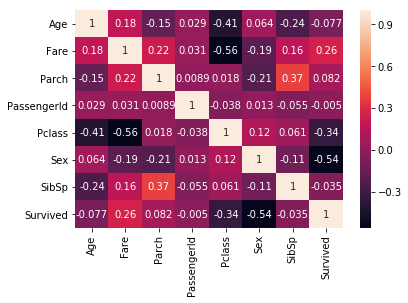

In [16]:
sns.heatmap(df.corr(),annot=True);plt.show()

In [132]:
temp=df.groupby("Survived").size()
temp

Survived
0.00    549
1.00    342
dtype: int64

In [137]:
'{:.2f}'.format(temp[1]/float(temp[0]+temp[1]))

'0.38'

#### Sex

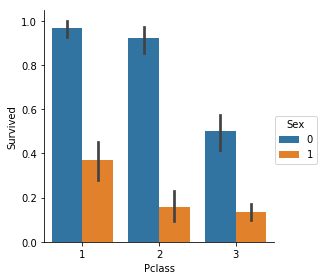

In [17]:
sns.factorplot(x="Pclass",y="Survived",hue="Sex",data=df,kind="bar")

#### Pclass

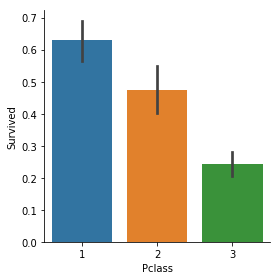

In [18]:
sns.factorplot(x="Pclass",y="Survived",data=df,kind="bar")

#### Fare

Only one missing value

In [19]:
df["Fare"]=df["Fare"].fillna(df["Fare"].median())

c:\python27\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


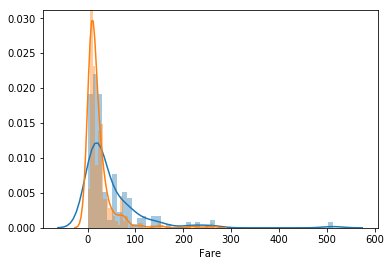

In [20]:
sns.distplot(df["Fare"][(df["Fare"].notnull())&(df["Survived"]==1)],bins=50)
sns.distplot(df["Fare"][(df["Fare"].notnull())&(df["Survived"]==0)],bins=50)

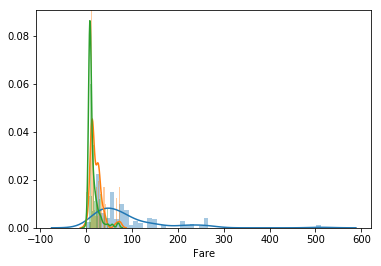

In [21]:
sns.distplot(df["Fare"][(df["Fare"].notnull())&(df["Pclass"]==1)],bins=50)
sns.distplot(df["Fare"][(df["Fare"].notnull())&(df["Pclass"]==2)],bins=50)
sns.distplot(df["Fare"][(df["Fare"].notnull())&(df["Pclass"]==3)],bins=50)

In [254]:
df["LogFare"]=df["Fare"].apply(lambda x: math.log(x+1))

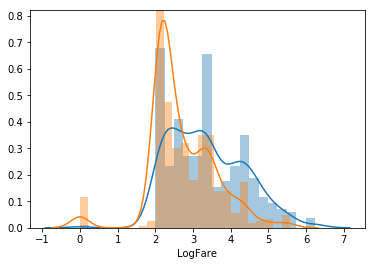

In [256]:
sns.distplot(df["LogFare"][(df["LogFare"].notnull())&(df["Survived"]==1)],bins=25)
sns.distplot(df["LogFare"][(df["LogFare"].notnull())&(df["Survived"]==0)],bins=25)

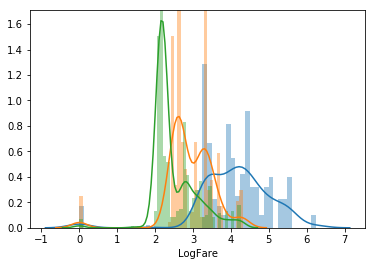

In [258]:
sns.distplot(df["LogFare"][(df["LogFare"].notnull())&(df["Pclass_1"]==1)],bins=50)
sns.distplot(df["LogFare"][(df["LogFare"].notnull())&(df["Pclass_2"]==1)],bins=50)
sns.distplot(df["LogFare"][(df["LogFare"].notnull())&(df["Pclass_3"]==1)],bins=50)

#### Age

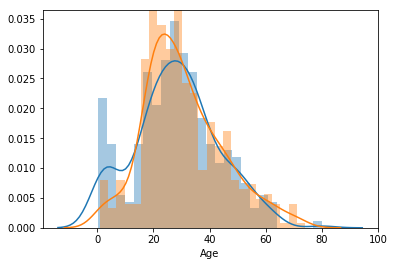

In [22]:
sns.distplot(df["Age"][(df["Age"].notnull())&(df["Survived"]==1)],bins=25)
sns.distplot(df["Age"][(df["Age"].notnull())&(df["Survived"]==0)],bins=25)

In [153]:
df["Age"].describe()

count   1309.000
mean      29.178
std       13.274
min        0.170
25%       22.000
50%       26.000
75%       37.000
max       80.000
Name: Age, dtype: float64

In [199]:
df["AgeGroup"]=pd.cut(df["Age"],[0,5,15,20,25,60,85],labels=[1,2,3,4,5,6])

In [200]:
pd.crosstab(df.Survived,df.AgeGroup)

AgeGroup,1,2,3,4,5,6
Survived,,,,,,
0.000,13,34,63,167,255,17
1.000,31,18,36,72,180,5


#### SibSp, Parch, Embarked

In [23]:
df.groupby("Embarked").size()

Embarked
C    270
Q    123
S    914
dtype: int64

Only 2 embarked missing

In [24]:
df["Embarked"]=df["Embarked"].fillna(df["Embarked"].mode()[0])

In [25]:
features=["SibSp","Parch","Embarked"]

In [26]:
d={}
for f in features:
    temp=df.groupby(["Survived",f]).size()
    d[f]=pd.concat([temp[0],temp[1]],axis=1).fillna(0)

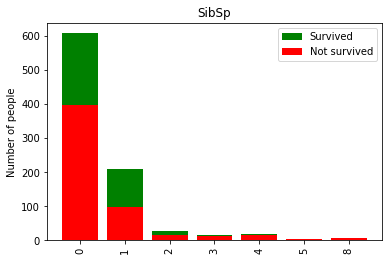

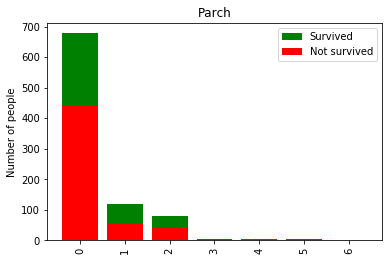

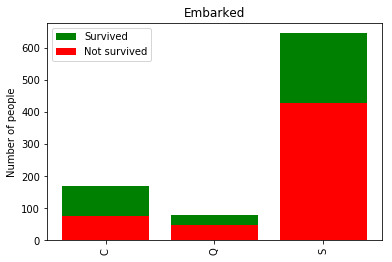

In [27]:
for f in features:
    plt.bar(np.arange(len(d[f][1])),d[f][1],bottom=d[f][0],label="Survived",color="g")
    plt.bar(np.arange(len(d[f][0])),d[f][0],label="Not survived",color="r")
    plt.xticks(np.arange(len(d[f][0])),d[f].index.values,rotation=90)
    plt.ylabel("Number of people")
    plt.title(f)
    plt.legend()
    plt.show()
    

### Filling missing values

#### Age

Text(0.5,1,'Not Survived')

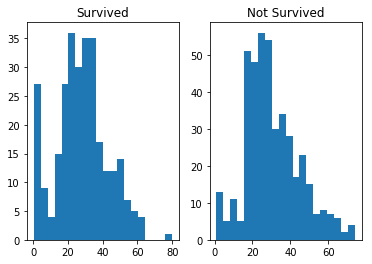

In [28]:
plt.subplot(1,2,1)
plt.hist(df["Age"][(df["Age"].notnull())&(df["Survived"]==1)],bins=20)
plt.title("Survived")

plt.subplot(1,2,2)
plt.hist(df["Age"][(df["Age"].notnull())&(df["Survived"]==0)],bins=20)
plt.title("Not Survived")

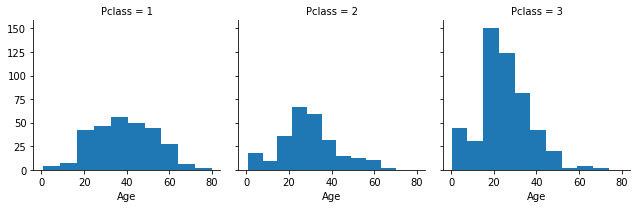

In [29]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="Pclass").map(plt.hist,"Age")

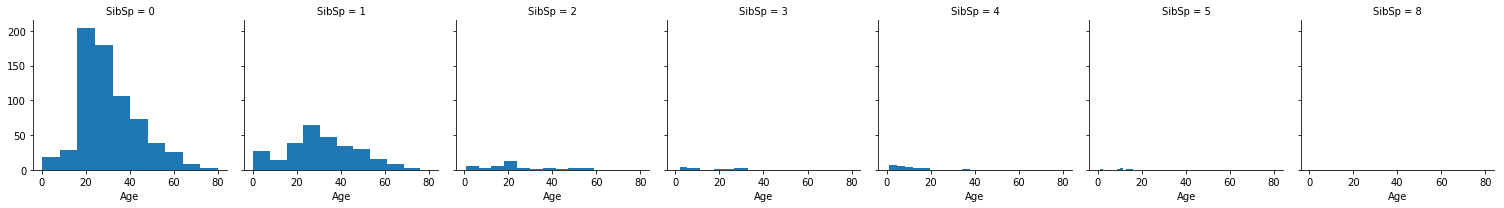

In [30]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="SibSp").map(plt.hist,"Age")

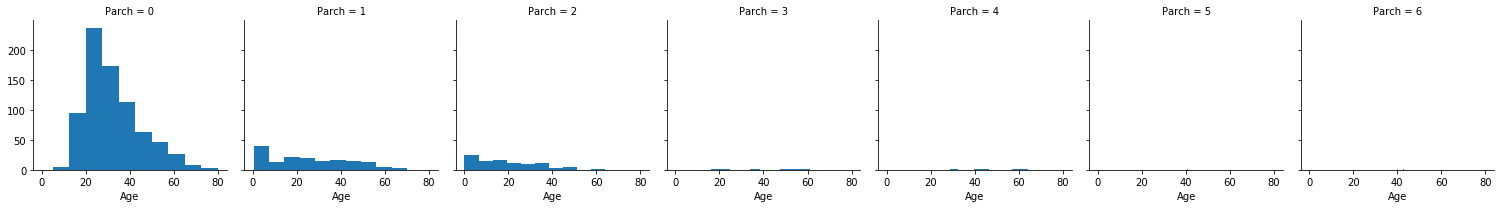

In [31]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="Parch").map(plt.hist,"Age")

In [32]:
index_age=df[df["Age"].isnull()].index.values
median=df["Age"][df["Age"].notnull()].median()
for i in index_age: 
    Pclass,Parch,SibSp=df.loc[i,"Pclass"],df.loc[i,"Parch"],df.loc[i,"SibSp"]
    subset=df["Age"][(df["Pclass"]==Pclass)&(df["Parch"]==Parch)&(df["SibSp"]==SibSp)]
    if subset.any():
        median_s=int(subset.median())
        df.loc[i,"Age"]=median_s
    else:
        df.loc[i,"Age"]=median   

### Feature engineering

In [33]:
def find_deck(cabin):
    try:
        match=re.search(r'[A-Z]',str(cabin))
        return match.group()
    except AttributeError:
        return 0

In [34]:
def survivors_ticket(index):
    ticketnr=df.loc[index,"Ticket"]
    temp=df[df["Ticket"]==ticketnr]
    if index<=890:
        survived=temp["Survived"].sum()-df.loc[index,"Survived"]
    else:
        survived=temp["Survived"].sum()
    if survived == 0:
        return 0
    if survived >0:
        return 1

In [35]:
def find_title(name):
    match=re.search(r",\s[A-Za-z]+",str(name))
    return match.group()[2:]

In [36]:
def family_size(size):
    if size==0:
        return "Single"
    if (size>=1) & (size<=3):
        return "Small"
    if size>=4:
        return "Large"

In [37]:
df["Deck"]=df["Cabin"].apply(find_deck)    
df["SurvivorsTicket"]=pd.Series(df.index).apply(survivors_ticket)
df["DeckKnown"]=df["Deck"].apply(lambda x: 1 if x else 0)
df["Title"]=df["Name"].apply(find_title)
df["Title"]=df["Title"].replace(["Capt","Col","Don","Dr","Jonkheer","Lady","Major",
                                 "Mlle","Mme","Ms","Rev","Sir","the","Dona"],"rare")
df["Size"]=df["SibSp"]+df["Parch"]
df["FSize"]=df["Size"].apply(family_size)

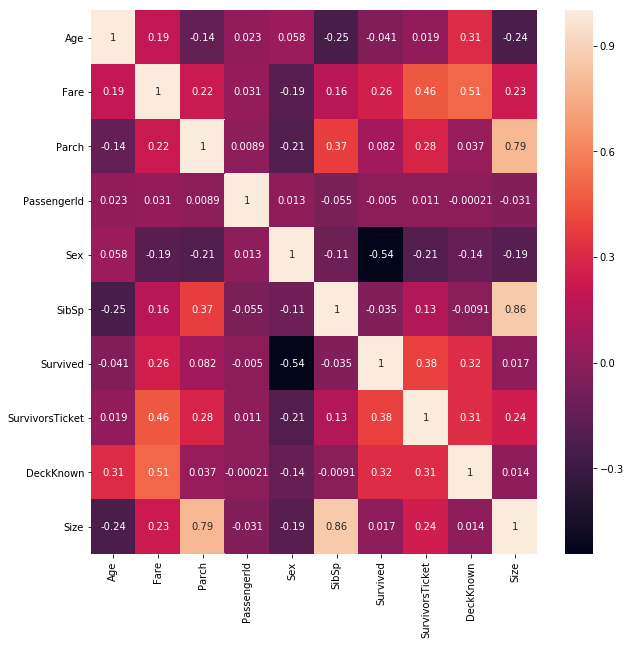

In [241]:
plt.figure(figsize=(10,10))
sns.heatmap(df.iloc[:,:15].corr(),annot=True)

### Drop features and get dummies

In [33]:
#df.drop(labels=["Name","PassengerId","Ticket","Cabin","Deck","Embarked",\
#              "SibSp","Size","Parch"],axis=1,inplace=True)

In [42]:
df=pd.get_dummies(df,columns=["Pclass","FSize","Title"])

In [201]:
df=pd.get_dummies(df,columns=["AgeGroup"])

In [208]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,...,"AgeGroup_(25, 35]","AgeGroup_(35, 45]","AgeGroup_(45, 60]","AgeGroup_(60, 85]",AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,AgeGroup_6
0,22.000,NaN,S,7.250,"Braund, Mr. Owen Harris",0,1,1,1,0.000,...,0,0,0,0,0,0,0,1,0,0
1,38.000,C85,C,71.283,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,1,1.000,...,0,1,0,0,0,0,0,0,1,0
2,26.000,NaN,S,7.925,"Heikkinen, Miss. Laina",0,3,0,0,1.000,...,1,0,0,0,0,0,0,0,1,0
3,35.000,C123,S,53.100,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,1,1.000,...,1,0,0,0,0,0,0,0,1,0
4,35.000,NaN,S,8.050,"Allen, Mr. William Henry",0,5,1,0,0.000,...,1,0,0,0,0,0,0,0,1,0


### Machine learning

I split my data into 3 partitions. Training set, test set and real test set. I also use cv on training set. 

In [209]:
X_full=df.drop(labels=["Survived"],axis=1)[:len(train)]
y_full=df["Survived"][:len(train)]
test=df.drop(labels=["Survived"],axis=1)[len(train):]

In [210]:
X_train,X_test,y_train,y_test=train_test_split(X_full,y_full,test_size=0.25,shuffle=True,random_state=42)

In [211]:
X_train.describe()

,Age,Fare,Parch,PassengerId,Sex,SibSp,SurvivorsTicket,DeckKnown,Size,Pclass_1,...,"AgeGroup_(25, 35]","AgeGroup_(35, 45]","AgeGroup_(45, 60]","AgeGroup_(60, 85]",AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,AgeGroup_6
count,668.000,668.000,668.000,668.000,668.000,668.000,668.000,668.000,668.000,668.000,...,668.000,668.000,668.000,668.000,668.000,668.000,668.000,668.000,668.000,668.000
mean,28.789,32.179,0.373,447.451,0.657,0.554,0.241,0.223,0.927,0.228,...,0.243,0.148,0.097,0.018,0.057,0.057,0.105,0.275,0.488,0.018
std,13.392,51.604,0.796,258.038,0.475,1.185,0.428,0.417,1.693,0.420,...,0.429,0.356,0.297,0.133,0.232,0.232,0.307,0.447,0.500,0.133
min,0.420,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,22.000,7.925,0.000,221.750,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,26.000,14.400,0.000,452.500,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,36.000,30.500,0.000,673.500,1.000,1.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
max,80.000,512.329,6.000,891.000,1.000,8.000,1.000,1.000,10.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [192]:
X_test.describe()

,Age,Fare,Parch,PassengerId,Sex,SibSp,SurvivorsTicket,DeckKnown,Size,Pclass_1,...,Title_Mrs,Title_rare,"AgeGroup_(0, 5]","AgeGroup_(5, 15]","AgeGroup_(15, 20]","AgeGroup_(20, 25]","AgeGroup_(25, 35]","AgeGroup_(35, 45]","AgeGroup_(45, 60]","AgeGroup_(60, 85]"
count,223.000,223.000,223.000,223.000,223.000,223.000,223.000,223.000,223.000,223.000,...,223.000,223.000,223.000,223.000,223.000,223.000,223.000,223.000,223.000,223.000
mean,29.862,32.279,0.408,441.655,0.619,0.430,0.184,0.247,0.839,0.287,...,0.161,0.031,0.027,0.063,0.130,0.247,0.215,0.202,0.072,0.045
std,13.509,43.578,0.838,255.820,0.487,0.802,0.388,0.432,1.349,0.453,...,0.369,0.175,0.162,0.243,0.337,0.432,0.412,0.402,0.259,0.207
min,0.830,0.000,0.000,6.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,22.000,7.896,0.000,234.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,27.000,15.246,0.000,427.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,38.000,31.331,1.000,656.000,1.000,1.000,0.000,0.000,1.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,71.000,262.375,5.000,890.000,1.000,4.000,1.000,1.000,6.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [193]:
y_test.describe()

count   223.000
mean      0.399
std       0.491
min       0.000
25%       0.000
50%       0.000
75%       1.000
max       1.000
Name: Survived, dtype: float64

In [194]:
y_train.describe()

count   668.000
mean      0.379
std       0.485
min       0.000
25%       0.000
50%       0.000
75%       1.000
max       1.000
Name: Survived, dtype: float64

#### Cross-validation

In [52]:
clfs=[DecisionTreeClassifier(),SVC(),AdaBoostClassifier(),RandomForestClassifier(),KNeighborsClassifier(),GaussianNB(),
      XGBClassifier(),LogisticRegression()]

In [215]:
kfold=RepeatedStratifiedKFold(n_splits=5,n_repeats=1,random_state=42)

In [232]:
features=["Sex"]

In [216]:
def cross_validate(X_train=X_train,y_train=y_train,clfs=clfs,features=features,kfold=kfold,vis=True,table=True):
    outcomes={}
    names=[]
    mean_accuracy=[]
    std=[]
    for c in clfs: 
        name=c.__class__.__name__
        names.append(name)
        outcomes[name]=cross_val_score(c,X_train[features],y_train,cv=kfold,scoring="accuracy",verbose=0)
        mean_accuracy.append(outcomes[name].mean())
        std.append(outcomes[name].std())
    clf_results=pd.DataFrame({"Classifier":names,"Mean accuracy":mean_accuracy,"Standard Deviation":std})
    print "features: "+str(features)
    if table:
        display(clf_results)
    if vis:
        plt.bar(np.arange(len(clf_results)),clf_results["Mean accuracy"],yerr=clf_results["Standard Deviation"])
        plt.xticks(np.arange(len(clf_results)),clf_results["Classifier"],rotation=90)
        plt.show()      

In [233]:
features=["Sex","AgeGroup_1","AgeGroup_2","AgeGroup_3","AgeGroup_4","AgeGroup_5","AgeGroup_6"]

features: ['Sex', 'AgeGroup_1', 'AgeGroup_2', 'AgeGroup_3', 'AgeGroup_4', 'AgeGroup_5', 'AgeGroup_6']


,Classifier,Mean accuracy,Standard Deviation
0,DecisionTreeClassifier,0.805,0.020
1,SVC,0.793,0.026
2,AdaBoostClassifier,0.792,0.027
3,RandomForestClassifier,0.804,0.018
4,KNeighborsClassifier,0.787,0.034
5,GaussianNB,0.795,0.027
6,XGBClassifier,0.805,0.020
7,LogisticRegression,0.792,0.027


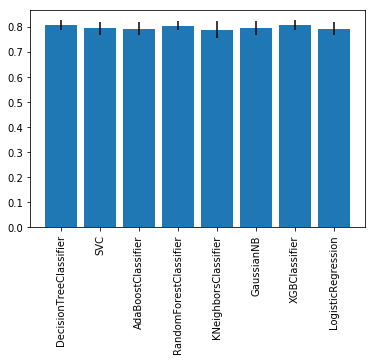

In [231]:
cross_validate(features=features)

### Parameter tuning

In [138]:
tuning_results={}

In [139]:
def do_tune(clf_single,parameters,name):
    clf=GridSearchCV(clf_single,parameters,cv=kfold,scoring="accuracy",verbose=1,n_jobs=-1)
    clf.fit(X_full,y_full)
    tuning_results[name]=[clf.best_score_,clf.best_params_,clf.best_estimator_]
    return

In [140]:
parameters_AB={"learning_rate":[0.1,0.2,0.4,1],"n_estimators":[50],"base_estimator":[DecisionTreeClassifier()],"algorithm":\
              ["SAMME","SAMME.R"]}
parameters_RF = {"max_depth": [None],"max_features": [1, 3, 10],"min_samples_split": [2, 3, 10],"min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],"n_estimators" :[100,300],"criterion": ["gini"]}
parameters_logr={"C":[0.001,0.01,0.1,1,10,100,1000]}
parameters_xgb={"max_depth":[3,5,7,9,11,13,17,20],"learning_rate":[0.01,0.1]}


In [141]:
do_tune(adaboost,parameters_AB,"adaboost")
do_tune(rf,parameters_RF,"rf")
do_tune(logr,parameters_logr,"logr")
do_tune(xgb,parameters_xgb,"xgb")

Fitting 20 folds for each of 8 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.6min finished


Fitting 20 folds for each of 54 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  4.5min finished


Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   42.2s finished


Fitting 20 folds for each of 16 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   17.8s finished


In [142]:
results,keys,clf_best=[],[],[]
for k in tuning_results.keys():
    keys.append(k)
    results.append(tuning_results[k][0])   
    clf_best.append(tuning_results[k][2])

In [143]:
pd.DataFrame({"name":keys,"tuned accuracy":results})

,name,tuned accuracy
0,xgb,0.845960
1,rf,0.846521
2,logr,0.840067
3,adaboost,0.810887


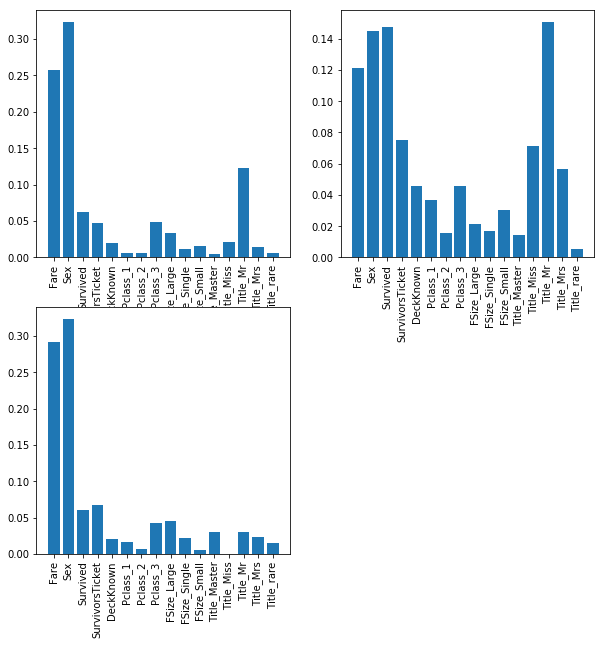

In [144]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.bar(np.arange(len(df.columns)-1),tuning_results["adaboost"][2].feature_importances_)
plt.xticks(np.arange(len(df.columns)-1),df.columns[1:],rotation=90)
plt.subplot(2,2,2)
plt.bar(np.arange(len(df.columns)-1),tuning_results["rf"][2].feature_importances_)
plt.xticks(np.arange(len(df.columns)-1),df.columns[1:],rotation=90)
plt.subplot(2,2,3)
plt.bar(np.arange(len(df.columns)-1),tuning_results["xgb"][2].feature_importances_)
plt.xticks(np.arange(len(df.columns)-1),df.columns[1:],rotation=90)
plt.show()

In [145]:
clf_best

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features=1, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', ran

In [146]:
pred_xgb=clf_best[0].predict(test)
pred_rf=clf_best[1].predict(test)
pred_logr=clf_best[2].predict(test)
pred_ab=clf_best[3].predict(test)

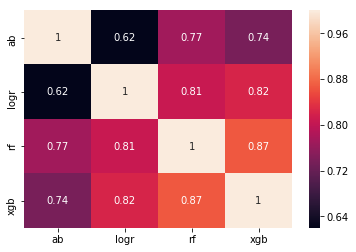

In [147]:
sns.heatmap(pd.DataFrame({"xgb":pred_xgb,"rf":pred_rf,"logr":pred_logr,"ab":pred_ab}).corr(),annot=True)

### Output

In [148]:
submission=pd.concat([testId,pd.Series(pred_xgb).astype(int)],axis=1)

In [149]:
submission.columns=["PassengerId","Survived"]

In [294]:
submission.to_csv("SecondSubmission.csv",index=False)

In [150]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


PL score is 0.775 while CV score is 0.845. 

In [152]:
from scipy.stats import binom

In [171]:
binom.cdf(155,200,0.845)

0.005754998110640135